In [31]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import pickle
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_scorefrom sklearn import preprocessing
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

###### Loading dataset

In [89]:
data = pd.read_csv('StudentMentalHealth.csv')
data.head()

,Timestamp,Choose your gender,Age,What is your course?,Your current year of Study,What is your CGPA?,Marital status,Do you have Depression?,Do you have Anxiety?,Do you have Panic attack?,Did you seek any specialist for a treatment?
0,8/7/2020 12:02,Female,18.0,Engineering,year 1,3.00 - 3.49,No,Yes,No,Yes,No
1,8/7/2020 12:04,Male,21.0,Islamic education,year 2,3.00 - 3.49,No,No,Yes,No,No
2,8/7/2020 12:05,Male,19.0,BIT,Year 1,3.00 - 3.49,No,Yes,Yes,Yes,No
3,8/7/2020 12:06,Female,22.0,Laws,year 3,3.00 - 3.49,Yes,Yes,No,No,No
4,8/7/2020 12:13,Male,23.0,Mathemathics,year 4,3.00 - 3.49,No,No,No,No,No


###### Renaming columns

In [90]:
data.columns=['Timestamp','Gender','Age','Course','Year_of_Study','CGPA','Marital_Status','Depression','Anxiety','Panic_Atack','Treatment']

###### Checking missing values

In [91]:
data.isnull().sum()

Timestamp         0
Gender            0
Age               1
Course            0
Year_of_Study     0
CGPA              0
Marital_Status    0
Depression        0
Anxiety           0
Panic_Atack       0
Treatment         0
dtype: int64

###### Filling the missing value with the median

In [92]:
data['Age'].fillna(data['Age'].median(),inplace=True)

###### Removing the timestamp column

In [93]:
data = data.drop('Timestamp' , axis=1)

###### Extracting the year of study

In [94]:
data['Year_of_Study'] = data['Year_of_Study'].astype(str).str.extract('(\d+)').astype(int)

###### Calculating the average CPGA

In [95]:
def calculate_cgpa(x):
    if isinstance(x,str):
        first,second=x.split('-')
        return (float(first.strip())+float(second.strip()))/2
    else:
        return x
data['CGPA']=data['CGPA'].apply(calculate_cgpa)

###### Applying LabelEncoder to transform categorical columns

In [97]:
labelEncoder = preprocessing.LabelEncoder()
cat_cols=['Course','Gender','Marital_Status','Depression','Anxiety','Panic_Atack','Treatment']
mapping_dict ={}

for col in cat_cols:
    data[col]=labelEncoder.fit_transform(data[col])
    le_name_mapping = dict(zip(labelEncoder.classes_,labelEncoder.transform(labelEncoder.classes_)))
    mapping_dict[col]= le_name_mapping
print(mapping_dict, "\n" )

{'Course': {'ALA': 0, 'Accounting ': 1, 'BCS': 2, 'BENL': 3, 'BIT': 4, 'Banking Studies': 5, 'Benl': 6, 'Biomedical science': 7, 'Biotechnology': 8, 'Business Administration': 9, 'CTS': 10, 'Communication ': 11, 'DIPLOMA TESL': 12, 'Diploma Nursing': 13, 'ENM': 14, 'Econs': 15, 'Engine': 16, 'Engineering': 17, 'Fiqh': 18, 'Fiqh fatwa ': 19, 'Human Resources': 20, 'Human Sciences ': 21, 'IT': 22, 'Irkhs': 23, 'Islamic Education': 24, 'Islamic education': 25, 'KENMS': 26, 'KIRKHS': 27, 'KOE': 28, 'Kirkhs': 29, 'Koe': 30, 'Kop': 31, 'Law': 32, 'Laws': 33, 'MHSC': 34, 'Malcom': 35, 'Marine science': 36, 'Mathemathics': 37, 'Nursing ': 38, 'Pendidikan Islam': 39, 'Pendidikan Islam ': 40, 'Pendidikan islam': 41, 'Psychology': 42, 'Radiography': 43, 'TAASL': 44, 'Usuluddin ': 45, 'engin': 46, 'koe': 47, 'psychology': 48}, 'Gender': {'Female': 0, 'Male': 1}, 'Marital_Status': {'No': 0, 'Yes': 1}, 'Depression': {'No': 0, 'Yes': 1}, 'Anxiety': {'No': 0, 'Yes': 1}, 'Panic_Atack': {'No': 0, 'Yes':

###### Saving the preprocessing steps into a pickle file

In [98]:
preprocessing_steps = {
    'label_encoder': labelEncoder,
    'label_mapping': le_name_mapping
}

with open('preprocessing_steps.pkl', 'wb') as file:
    pickle.dump(preprocessing_steps, file)


###### Spliting the data into features and target

In [99]:
X = data.drop('Depression', axis=1)
y = data['Depression']

###### Spliting the data into training, testing, and validation sets

In [100]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

###### Evaluate function

In [101]:
def evaluate(sk_model, x_test, y_test):
    eval_acc = sk_model.score(x_test, y_test)
    preds = sk_model.predict(x_test)
    auc_score = roc_auc_score(y_test, preds)
    mlflow.log_metric("eval_acc", eval_acc)
    mlflow.log_metric("auc_score", auc_score)
    print(f"AUC Score: {auc_score:.3%}")
    print(f"Evaluation Accuracy: {eval_acc:.3%}")
    
    plt.clf()
    conf_matrix = confusion_matrix(y_test, preds)
    ax = sns.heatmap(conf_matrix, annot=True, fmt='g')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("Confusion Matrix")
    plt.savefig("sklearn_conf_matrix.png")
    mlflow.log_artifact("sklearn_conf_matrix.png")

###### Logistic Regression model training and evaluation

Train Accuracy: 85.000%
AUC Score: 70.833%
Evaluation Accuracy: 75.000%
Model run:  5436f753b726478599985088705e5827


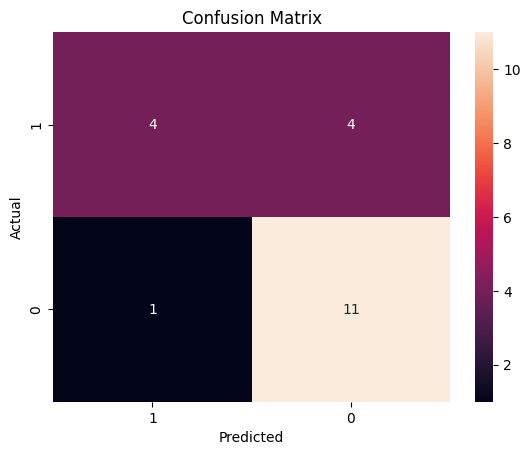

In [108]:
sk_model = LogisticRegression(random_state=None, max_iter=1000) 
mlflow.set_experiment("MentalHealth_experiment")

with mlflow.start_run():
    # Training on the training set
    sk_model = sk_model.fit(X_train, y_train)
    train_acc = sk_model.score(X_train, y_train)
    mlflow.log_metric("train_acc", train_acc)
    print(f"Train Accuracy: {train_acc:.3%}")

    # Evaluation on the test set
    evaluate(sk_model, X_test, y_test)

    # Log the model
    mlflow.sklearn.log_model(sk_model, "log_reg_model")

    print("Model run: ", mlflow.active_run().info.run_uuid)

# End the run
mlflow.end_run()

###### Decision Tree model training and evaluation

Decision Tree Train Accuracy: 100.000%
AUC Score: 70.833%
Evaluation Accuracy: 70.000%
Model run:  46b1663e96844e0c8aee8d4fff40f04a


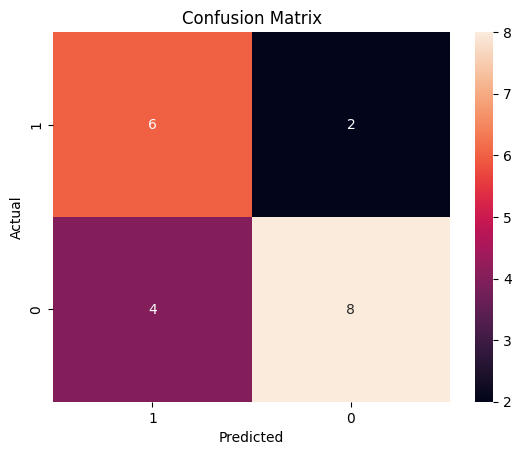

In [109]:
sk_model_dt = DecisionTreeClassifier(random_state=42)
mlflow.set_experiment("MentalHealth_experiment")

with mlflow.start_run():
    sk_model_dt = sk_model_dt.fit(X_train, y_train)
    train_acc_dt = sk_model_dt.score(X_train, y_train)
    mlflow.log_metric("train_acc", train_acc_dt)
    print(f"Decision Tree Train Accuracy: {train_acc_dt:.3%}")
    evaluate(sk_model_dt, X_test, y_test)
    mlflow.sklearn.log_model(sk_model_dt, "decision_tree_model")
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()

###### Random Forest model training and evaluation

Random Forest Train Accuracy: 100.000%
AUC Score: 81.250%
Evaluation Accuracy: 85.000%
Model run:  37c3626ae31e449eae4a73d089a7fe47


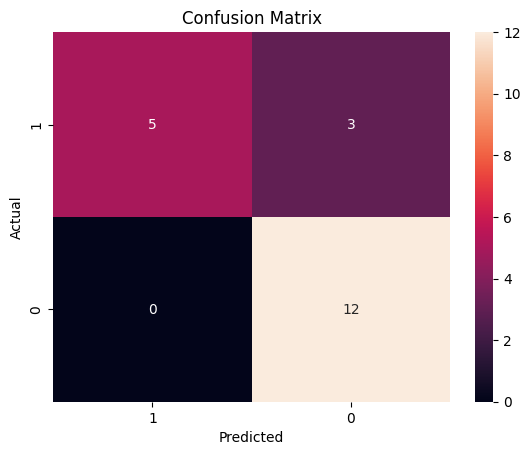

In [110]:
sk_model_rf = RandomForestClassifier(random_state=42)
mlflow.set_experiment("MentalHealth_experiment")

with mlflow.start_run():
    sk_model_rf = sk_model_rf.fit(X_train, y_train)
    train_acc_rf = sk_model_rf.score(X_train, y_train)
    mlflow.log_metric("train_acc", train_acc_rf)
    print(f"Random Forest Train Accuracy: {train_acc_rf:.3%}")
    evaluate(sk_model_rf, X_test, y_test)
    mlflow.sklearn.log_model(sk_model_rf, "random_forest_model")
    print("Model run: ", mlflow.active_run().info.run_uuid)

mlflow.end_run()

###### Gradient Boosting model training and evaluation

Gradient Boosting Train Accuracy: 100.000%
AUC Score: 75.000%
Evaluation Accuracy: 75.000%
Model run:  721872add195465d98cfc924e22e7033


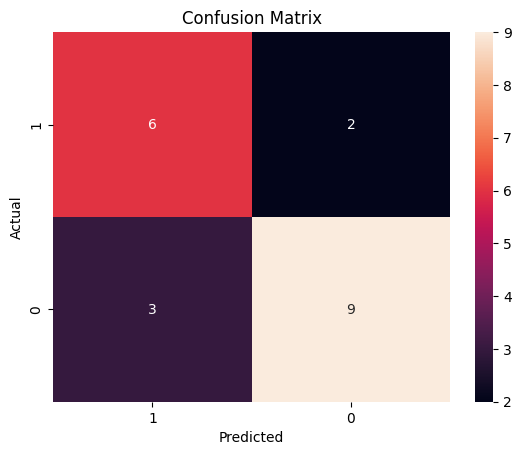

In [111]:
sk_model_gb = GradientBoostingClassifier(random_state=42)
mlflow.set_experiment("MentalHealth_experiment")

with mlflow.start_run():
    sk_model_gb = sk_model_gb.fit(X_train, y_train)
    train_acc_gb = sk_model_gb.score(X_train, y_train)
    mlflow.log_metric("train_acc", train_acc_gb)
    print(f"Gradient Boosting Train Accuracy: {train_acc_gb:.3%}")
    evaluate(sk_model_gb, X_test, y_test)
    mlflow.sklearn.log_model(sk_model_gb, "gradient_boosting_model")
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()

###### Support Vector Machine model training and evaluation

SVM Train Accuracy: 66.667%
AUC Score: 58.333%
Evaluation Accuracy: 65.000%
Model run:  566b39e1f4e6408f869ed84d377908e5


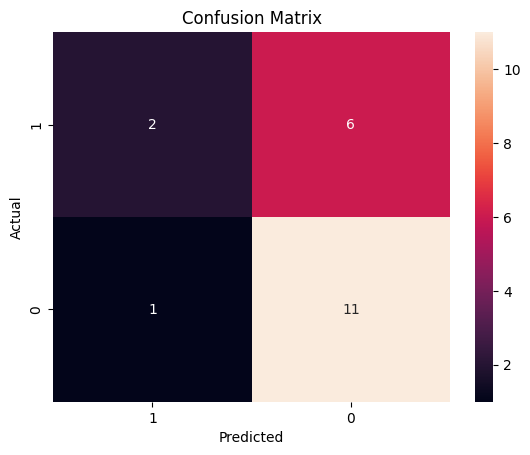

In [112]:
sk_model_svm = SVC(random_state=42)
mlflow.set_experiment("MentalHealth_experiment")

with mlflow.start_run():
    sk_model_svm = sk_model_svm.fit(X_train, y_train)
    train_acc_svm = sk_model_svm.score(X_train, y_train)
    mlflow.log_metric("train_acc", train_acc_svm)
    print(f"SVM Train Accuracy: {train_acc_svm:.3%}")
    evaluate(sk_model_svm, X_test, y_test)
    mlflow.sklearn.log_model(sk_model_svm, "svm_model")
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()
